In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf 
from tensorflow import keras

from sklearn.manifold import TSNE

In [3]:
df = pd.read_csv('classification_cleaned.csv')
df.head()

,alpha,delta,class,redshift,photometric_filters
0,135.689107,32.494632,0,0.634794,21.442149
1,144.826101,31.274185,0,0.779136,22.930232
2,142.188790,35.582444,0,0.644195,22.024390
3,338.741038,-0.402828,0,0.932346,21.779020
4,345.282593,21.183866,0,0.116123,17.395478


In [4]:
df.describe()

,alpha,delta,class,redshift,photometric_filters
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,0.621490,0.576661,20.311896
std,96.502241,19.644665,0.816778,0.730707,21.231872
min,0.005528,-18.785328,0.000000,-0.009971,-6669.000165
25%,127.518222,5.146771,0.000000,0.054517,18.906512
50%,180.900700,23.645922,0.000000,0.424173,20.894890
75%,233.895005,39.901550,1.000000,0.704154,21.794779
max,359.999810,83.000519,2.000000,7.011245,28.411403


In [5]:
# I am going to separate features and target columns 
X = df.drop('class', axis=1).values
y = df['class'].values

In [6]:
# My class column is imbalanced, so I should handle it
# For handling imbalanced data, there are many ways like oversampling, undersampling, SMOTE and  Class Weights
# I prefer to go with  Weighted Classes that model can pay more attention to the QSO and star 
# I need to find all the unique class labels in my target column 
# for calculating the weights of each class that QSO and star can get more weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)
# QSO is 1 and it's weight is 1.757 
# Source : https://machinelearningmastery.com/5-effective-ways-to-handle-imbalanced-data-in-machine-learning/

Class weights: {0: 0.5607424229680097, 1: 1.757994479897333, 2: 1.5436386650612826}


In [7]:
# I am going to split the X and y before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Feature Scaling:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# I used stratify=y to maintain class balance in splitting
# Also, I fit the scaler only for training data, then transform validation and test to avoid data leakage
# Scale only learns mean and std from training data
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Labeling for the model because softmax  gives probabilities for each class
#  One hot encoding let me to  compare these probabilities with true labels using categorical crossentropy
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
print("One hot encoded:", y_train[0])

Training set: (70000, 4)
Validation set: (15000, 4)
Test set: (15000, 4)
One hot encoded: [1. 0. 0.]


<h1><center>Building the Neural Network Architecture</center><h1>

In [8]:
# I am going to build the model now, I will use Sequential model 
model = Sequential()
model.add(Input(shape=(4,))) 
model.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323 (1.26 KB)

 Trainable params: 323 (1.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compiling the model:
# I am going to use catergorical crossentropy because it is used for multi class 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=False)])
# Early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=7, verbose=1)
# Save best model
checkpoint = ModelCheckpoint('best_astro_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [10]:
# Training the Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=256, class_weight=class_weight_dict,
                    callbacks=[early_stop, reduce_lr, checkpoint], verbose=1)

Epoch 1/30
265/274 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.4427 - auc: 0.6716 - loss: 0.9071
Epoch 1: val_accuracy improved from None to 0.75047, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5869 - auc: 0.8083 - loss: 0.7177 - val_accuracy: 0.7505 - val_auc: 0.9187 - val_loss: 0.5676 - learning_rate: 0.0010
Epoch 2/30
227/274 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.7621 - auc: 0.9213 - loss: 0.4501
Epoch 2: val_accuracy improved from 0.75047 to 0.84633, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7876 - auc: 0.9378 - loss: 0.4150 - val_accuracy: 0.8463 - val_auc: 0.9635 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 3/30
228/274 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.8436 - auc: 0.9606 - loss: 0.3429
Epoch 3: val_accuracy improved from 0.84633 to 0.89307, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - auc: 0.9640 - loss: 0.3342 - val_accuracy: 0.8931 - val_auc: 0.9725 - val_loss: 0.3234 - learning_rate: 0.0010
Epoch 4/30
228/274 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.8832 - auc: 0.9696 - loss: 0.2963
Epoch 4: val_accuracy improved from 0.89307 to 0.91300, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8906 - auc: 0.9716 - loss: 0.2967 - val_accuracy: 0.9130 - val_auc: 0.9770 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 5/30
228/274 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9010 - auc: 0.9739 - loss: 0.2727
Epoch 5: val_accuracy improved from 0.91300 to 0.91673, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9042 - auc: 0.9751 - loss: 0.2698 - val_accuracy: 0.9167 - val_auc: 0.9783 - val_loss: 0.2731 - learning_rate: 0.0010
Epoch 6/30
232/274 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.9102 - auc: 0.9765 - loss: 0.2635
Epoch 6: val_accuracy improved from 0.91673 to 0.92487, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9126 - auc: 0.9775 - loss: 0.2552 - val_accuracy: 0.9249 - val_auc: 0.9807 - val_loss: 0.2547 - learning_rate: 0.0010
Epoch 7/30
237/274 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.9192 - auc: 0.9794 - loss: 0.2389
Epoch 7: val_accuracy improved from 0.92487 to 0.92607, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9193 - auc: 0.9793 - loss: 0.2389 - val_accuracy: 0.9261 - val_auc: 0.9814 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 8/30
234/274 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9221 - auc: 0.9805 - loss: 0.2340
Epoch 8: val_accuracy improved from 0.92607 to 0.92707, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9226 - auc: 0.9806 - loss: 0.2392 - val_accuracy: 0.9271 - val_auc: 0.9819 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 9/30
228/274 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9244 - auc: 0.9815 - loss: 0.2229
Epoch 9: val_accuracy improved from 0.92707 to 0.93167, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9268 - auc: 0.9817 - loss: 0.2220 - val_accuracy: 0.9317 - val_auc: 0.9829 - val_loss: 0.2371 - learning_rate: 0.0010
Epoch 10/30
231/274 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.9289 - auc: 0.9819 - loss: 0.2200
Epoch 10: val_accuracy improved from 0.93167 to 0.93827, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9306 - auc: 0.9826 - loss: 0.2152 - val_accuracy: 0.9383 - val_auc: 0.9840 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 11/30
236/274 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.9300 - auc: 0.9828 - loss: 0.2107
Epoch 11: val_accuracy improved from 0.93827 to 0.94067, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9335 - auc: 0.9834 - loss: 0.2081 - val_accuracy: 0.9407 - val_auc: 0.9847 - val_loss: 0.2210 - learning_rate: 0.0010
Epoch 12/30
234/274 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9342 - auc: 0.9835 - loss: 0.2074
Epoch 12: val_accuracy improved from 0.94067 to 0.94433, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9362 - auc: 0.9841 - loss: 0.2033 - val_accuracy: 0.9443 - val_auc: 0.9860 - val_loss: 0.2041 - learning_rate: 0.0010
Epoch 13/30
233/274 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.9386 - auc: 0.9845 - loss: 0.2000
Epoch 13: val_accuracy improved from 0.94433 to 0.94733, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9383 - auc: 0.9847 - loss: 0.1986 - val_accuracy: 0.9473 - val_auc: 0.9862 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 14/30
235/274 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9401 - auc: 0.9855 - loss: 0.1939
Epoch 14: val_accuracy improved from 0.94733 to 0.94920, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9398 - auc: 0.9851 - loss: 0.1948 - val_accuracy: 0.9492 - val_auc: 0.9869 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 15/30
236/274 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.9433 - auc: 0.9853 - loss: 0.1944
Epoch 15: val_accuracy improved from 0.94920 to 0.94980, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9420 - auc: 0.9856 - loss: 0.1910 - val_accuracy: 0.9498 - val_auc: 0.9868 - val_loss: 0.1931 - learning_rate: 0.0010
Epoch 16/30
235/274 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.9432 - auc: 0.9855 - loss: 0.1866
Epoch 16: val_accuracy improved from 0.94980 to 0.95173, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9431 - auc: 0.9858 - loss: 0.1878 - val_accuracy: 0.9517 - val_auc: 0.9870 - val_loss: 0.1929 - learning_rate: 0.0010
Epoch 17/30
237/274 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.9403 - auc: 0.9853 - loss: 0.1937
Epoch 17: val_accuracy did not improve from 0.95173
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - auc: 0.9862 - loss: 0.1846 - val_accuracy: 0.9501 - val_auc: 0.9869 - val_loss: 0.1913 - learning_rate: 0.0010
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 14.


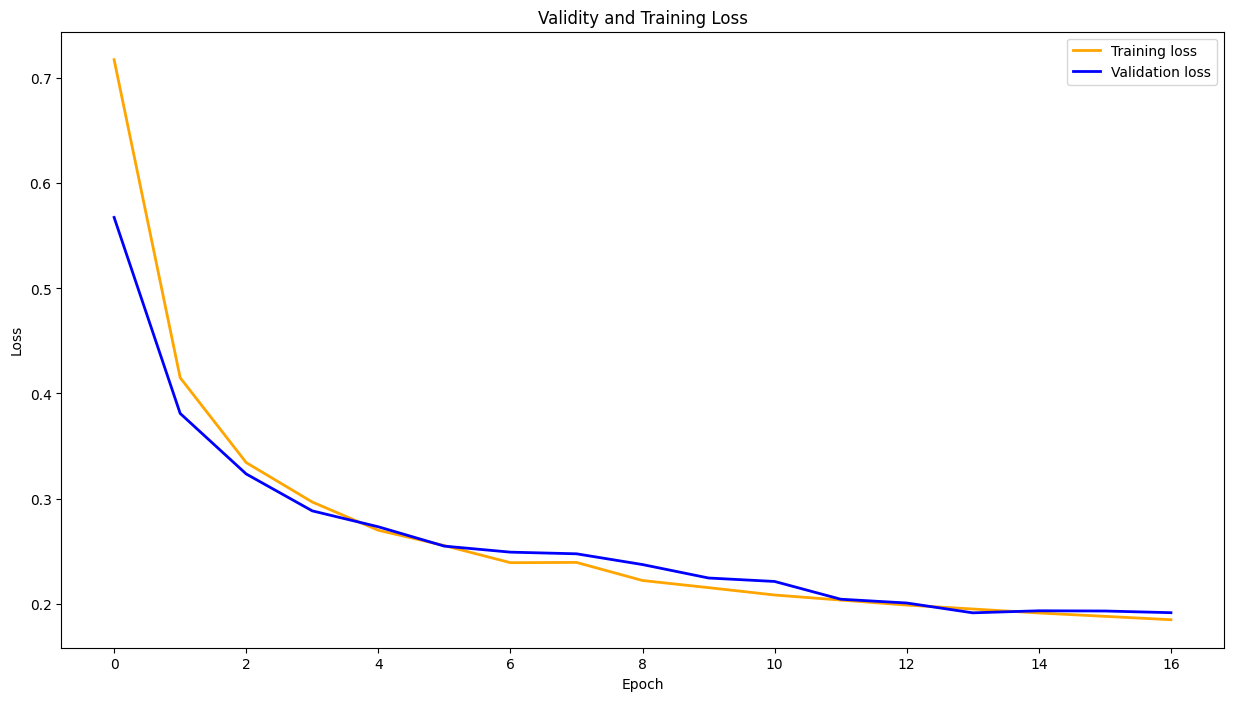

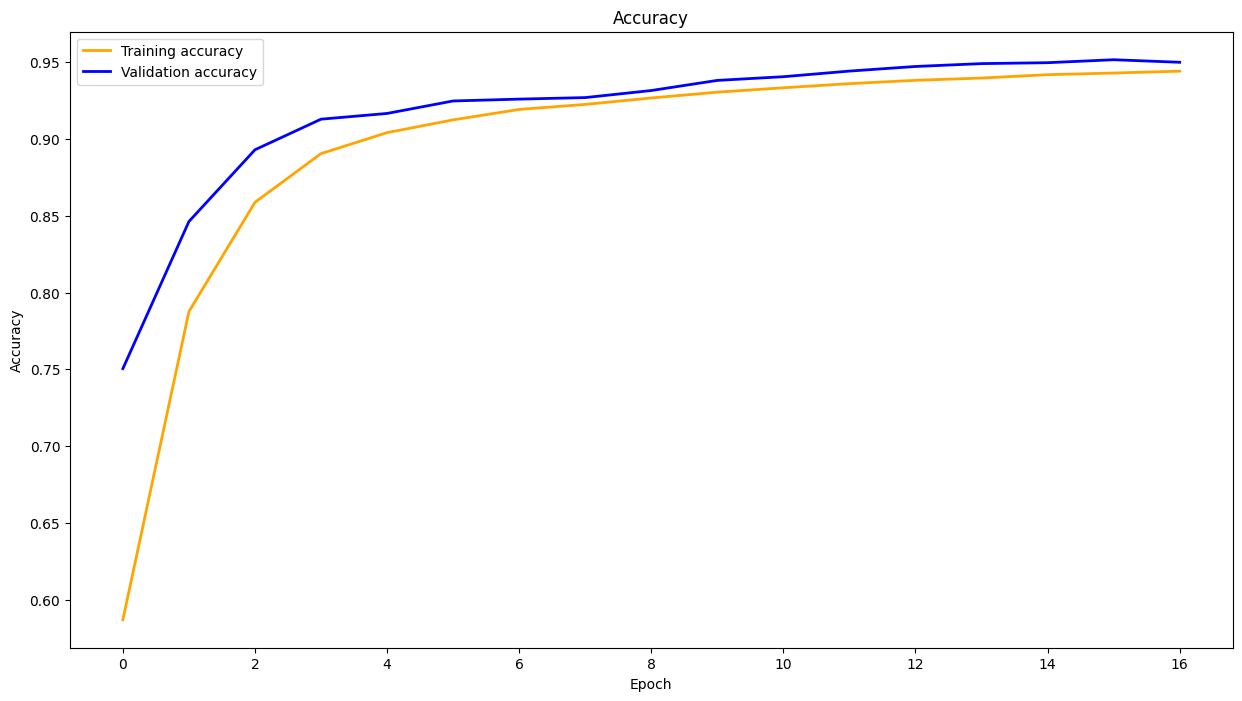

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Validity and Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['accuracy'], label='Training accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# Model learns quickly and  I don t see overfitting
# Val loss and train loss are matching 

In [12]:
# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test = np.argmax(y_test, axis=1)
# Detailed classification report
print("\nClassification Report:\n")
target_names = ['Star', 'Galaxy', 'QSO']
print(classification_report(y_test, y_pred, target_names=target_names))

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step

Classification Report:

              precision    recall  f1-score   support

        Star       0.96      0.95      0.96      8917
      Galaxy       0.93      0.88      0.90      2844
         QSO       0.93      1.00      0.97      3239

    accuracy                           0.95     15000
   macro avg       0.94      0.94      0.94     15000
weighted avg       0.95      0.95      0.95     15000



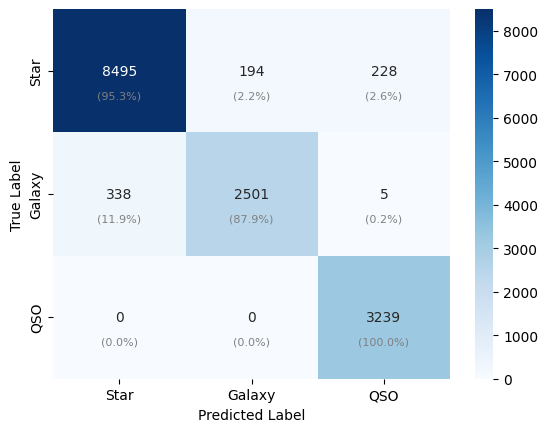

In [13]:
# Confusion Matrix 
confusion_matrix = confusion_matrix(y_test, y_pred)
# After getting the confusion matrix, I need to convert values to float and sum each row of matrix. for dividing each row by its total
# array must be 2D, so I use None to add new axis
confusion_matrix_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, None] * 100
sns.heatmap(confusion_matrix, fmt='d', annot=True, cmap='Blues', xticklabels=target_names, yticklabels=target_names)
# Adding new percentages to the confusion matrix
for  i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.7, f'({confusion_matrix_percent[i, j]:.1f}%)', 
                 ha='center', va='center', fontsize=8, color='gray')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() 
# I got the code structure from:
# https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
# Almost 11 % of Galaxies are misclassified as stars, I think it is because both have close redshift distributions

In [ ]:
#  Calculating Uncertainty Monte Carlo Dropout
predictions = []
# 10 times gernerating predictions

for _ in range(10):
    preds = model(X_test, training=True )
    predictions.append(preds)
# I set up the training=True in the model which means dropout is active during prediction
# The predictions will be different each time because of dropout


# Converting to array and calculating statistics
predictions = np.array(predictions)
mean_pred = np.mean(predictions, axis=0)
std_pred = np.std(predictions, axis=0)
uncertainty = np.mean(std_pred, axis=1)
print("Uncertainty in Predictions:\n", uncertainty)
# Source : https://medium.com/biased-algorithms/uncertainty-estimation-in-machine-learning-with-monte-carlo-dropout-72377f5ee276

Uncertainty in Predictions:
 [0.01599529 0.08005562 0.01030168 ... 0.02393548 0.03467895 0.00023008]


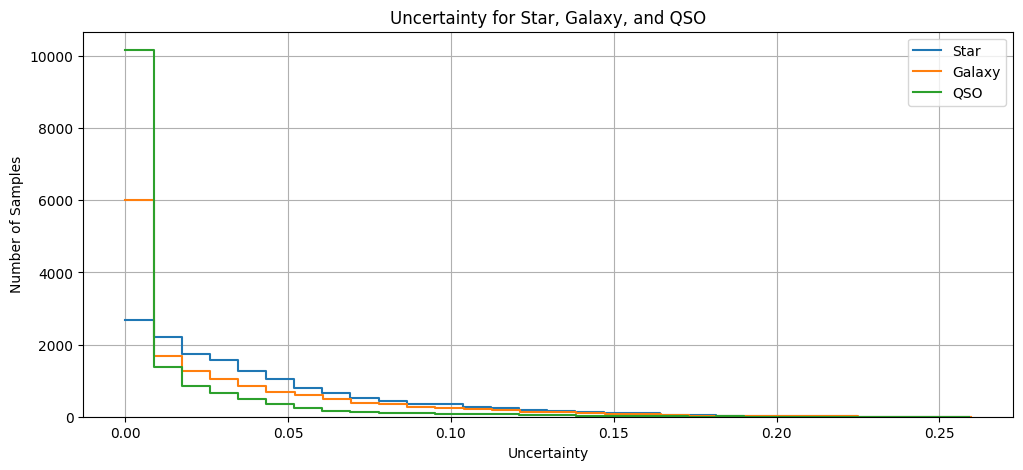

In [15]:
# Visualizing uncertainty 
plt.figure(figsize=(12, 5))
for i in range(3):
    sns.histplot(std_pred[:, i], label=target_names[i], bins=30, element='step', fill=False)
plt.title('Uncertainty for Star, Galaxy, and QSO')
plt.xlabel('Uncertainty')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend()
plt.show()
# I used MC Dropout and ran the model  10 times to get different predictions
# what I can see from the  graph is that the model has more confidence for most QSO, but few of them are hard for the model to classify 0.3
#  Model has less confidence for stars and galaxies that confuction shows the same thing. 